# Exploration of Sequential Monte Carlo / Weighted Particle Methods
Following [https://www.stats.ox.ac.uk/~doucet/doucet_johansen_tutorialPF2011.pdf](https://www.stats.ox.ac.uk/~doucet/doucet_johansen_tutorialPF2011.pdf).
Doucet is an SMC method pioneer, and he is currently a senior research scientist at Google DeepMind.

I'm not great at determining how much information is best for presentation. Feel free to skip whatever is not interesting to you. I've already pruned alot from the original tutorial, but this notebook is pretty long. The code portions are densest at the end of this notebook.
## Table of Contents 




# Stochastic volatility model described in Doucet's SMC tutorial
*So I couldn't figure out how to enable spellcheck on my local Jupyter Notebook server. If there are typos, please let me know by email: johnma@udel.edu*


Consider the stochastic processes, $\{X_n\}_{n \ge 0}$ modeling hidden Markov states of volatility for a specified financial instrument,
$$
X_n = \alpha X_{n-1} + \sigma V_n,
$$
and $\{Y_n\}_{n\ge 0}$,
$$
Y_n = \beta \exp(X_n / 2) W_n
$$
modeling observations of instrument price,
where $\sigma, \alpha, \beta$ are all real valued parameters,
$V_n \sim \mathcal{N}(0,1), W_n \sim \mathcal{N}(0,1)$, all iid.
Doucet describes the first hidden Markov state 
as $X_1 \sim \mathcal{N}\left(0, \frac{\sigma^2}{1-\alpha^2}\right).$ I think we can change the mean to tweak this, 
say for instance to model a live instrument started yesterday.

(This is a basic AR(1) process. I've found this resource detailing more rigorous models: [https://personal.ntu.edu.sg/nprivault/MA5182/stochastic-volatility.pdf](https://personal.ntu.edu.sg/nprivault/MA5182/stochastic-volatility.pdf). This notebook is focused on
exploring Sequential Monte Carlo, not as much on the economic modeling aspect itself.

But for now, how I understand this AR(1) is thus:
This is a simplified, countably indexed stochastic process modeling volatility.
The parameter alpha tunes how strongly the market remembers the previous state. Weaker values of alpha mean noisier markets, as the additive sigma noise takes over. Beta is a parameter tuning how reactive the market is to volatility.
)
# Let's run the stochastic process forward


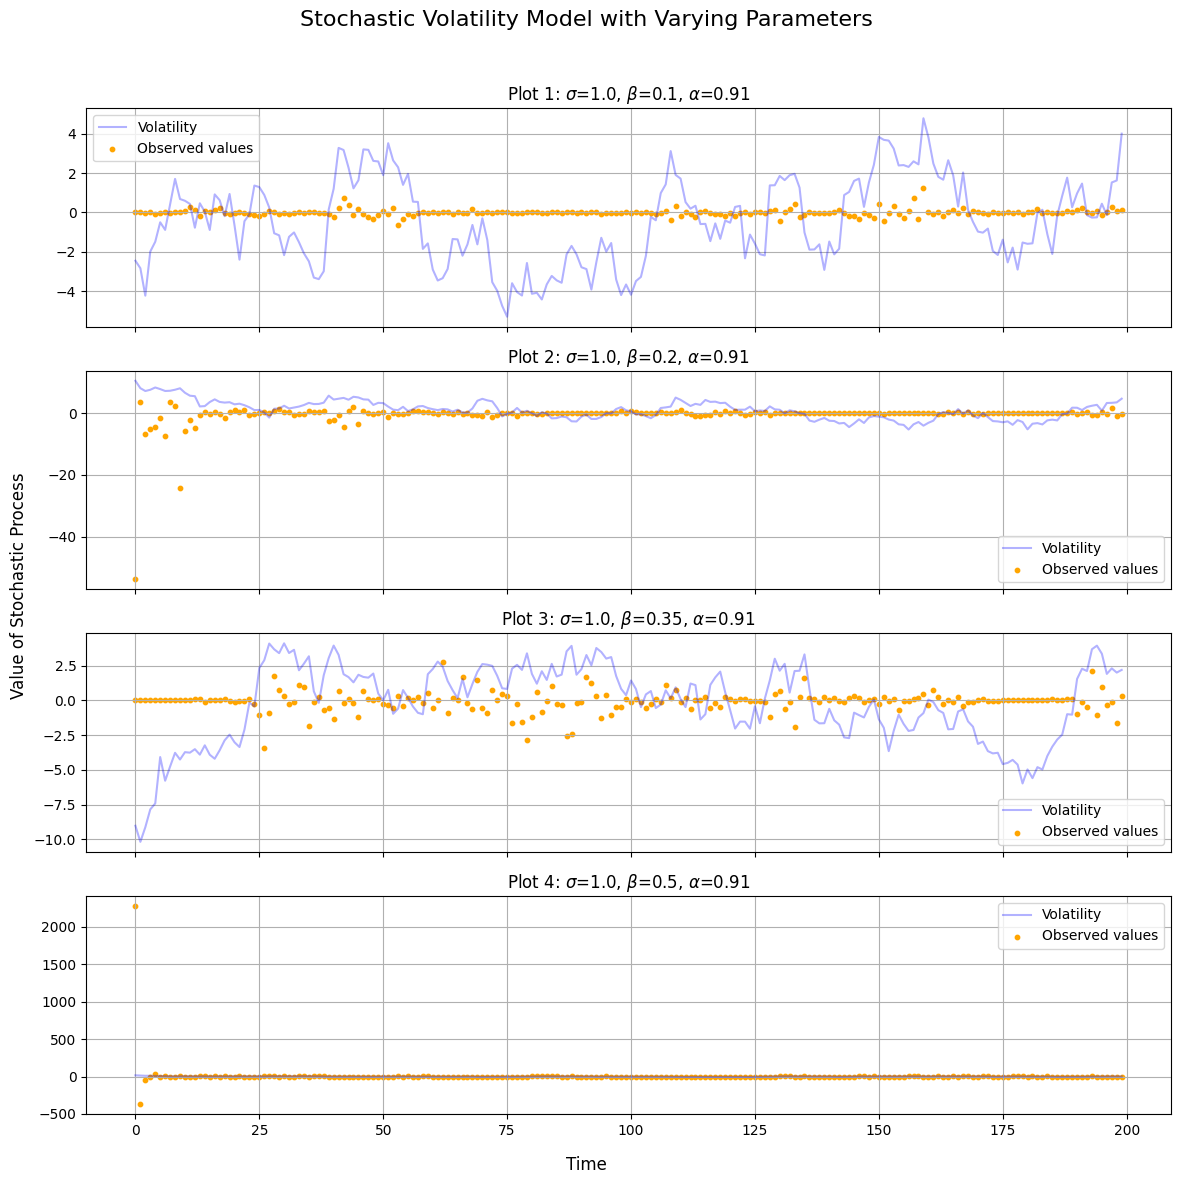

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Number of time steps
# We will use capital N for something else later
n = 200

# For multiple plots, keeping alpha and sigma fixed for now
sigma_param = [1.0, 1.0, 1.0, 1.0]
beta_param = [0.1, 0.2, 0.35, 0.5] 
alpha_param = [0.91, 0.91, 0.91, 0.91]

fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

for i in range(4):
    X = [0] * n
    Y = [0] * n

    sigma = sigma_param[i]
    beta = beta_param[i]
    alpha = alpha_param[i]

    X[0] = np.random.normal(0, sigma / (1 - alpha))
    Y[0] = beta * np.exp(X[0] / 2) * np.random.normal(0, 1)

    for t in range(1, n):
        X[t] = alpha * X[t - 1] + sigma * np.random.normal(0, 1)
        Y[t] = beta * np.exp(X[t] / 2) * np.random.normal(0, 1)

    axes[i].plot(X, label='Volatility', color='blue', alpha=0.3)
    axes[i].scatter(range(n), Y, label='Observed values', color='orange', s=10, alpha=1.0)
    axes[i].set_title(rf'Plot {i+1}: $\sigma$={sigma}, $\beta$={beta}, $\alpha$={alpha}')
    axes[i].legend()
    axes[i].grid(True)

# Shared labels
fig.suptitle('Stochastic Volatility Model with Varying Parameters', fontsize=16)
fig.supxlabel('Time')
fig.supylabel('Value of Stochastic Process')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Importantly... in this simple model, 
we have that $\{X_n\}_{n\ge 0}$ evolves according to the
transition density $f(x' \mid x)= \mathcal{N}(x'; \alpha x, \sigma^2)$, and
$\{Y_n\}_{n\ge 0}$ evolves according to the transition density $g(y\mid x) = \mathcal{N}(y; 0, \beta^2 \exp(x))$. We note that the given mean zero initial distribution ensures
the marginal distribution of each $X_n$ is also $\mathcal{N}\left(x;0,\frac{\sigma^2}{1-\alpha^2}\right)$, for all $n$.

# Filtering theory basics, skip if not interesting
*Skip to
[Sequential Monte Carlo methods](#Sequential-Monte-Carlo-methods)
if you'd like to skip the basics.*

*Skip to
[SIS modeling of our stochastic volatility model](#SIS-modeling-of-our-stochastic-volatility-model)
if you just want to view the code.*


Suppose we have  realizations of the observations $Y_{1:n} = y_{1:n}$.
We are interested in the sequential approximation of the distributions
$\{p(x_{1:n} \mid y_{1:n})\}_{n\ge 1}$ (and the marginal likelihoods $\{p(y_{1:n})\}_{n\ge 1}$). 
Generally we assume a prior distribution for $\{X_n\}_{n\ge 1}$ which can be factored 
\begin{equation}
p(x_{1:n}) = \mu(x_1) \prod_{k=2}^2 f(x_k \mid x_{k-1}), \tag{1}
\end{equation}
for initial distribution $\mu(x)$ and transition density $f(x_k \mid x_{k-1}),$ 
as well as a likelihood function factorizable as
\begin{equation}
p(y_{1:n} \mid x_{1:n}) = \prod_{k=1}^n g(y_k \mid x_k),\tag{2}
\end{equation}
for marginal density $g(y \mid x).$

By Bayes',
\begin{equation}
p(x_{1:n} \mid y_{1:n}) = \frac{p(x_{1:n}, y_{1:n})}{p(y_{1:n})},\tag{3}
\end{equation}
where 

\begin{equation}
p(x_{1:n}, y_{1:n}) = p(x_{1:n})p(y_{1:n}\mid x_{1:n}),\tag{4}
\end{equation} and 
\begin{equation}
p(y_{1:n}) = \int p(x_{1:n}, y_{1:n})\,dx_{1:n}.\tag{5}
\end{equation}

### We claim that ...
the general unnormalized posterior distribution $p(x_{1:n}, y_{1:n})$ described above satisfies the recursion
\begin{equation}
p(x_{1:n}, y_{1:n}) = p(x_{1:n-1}, y_{1:n-1}) f(x_n \mid x_{n-1}) g(y_n \mid x_n).\tag{6}
\end{equation}
To see this, directly apply (1) and (2) to (4).
 We can do something similar for the normalized posterior:
\begin{equation}
p(x_{1:n} \mid y_{1 : n}) = p(x_{1: n-1}\mid y_{1:n-1}) \frac{f(x_n \mid x_{n-1})g(y_n\mid x_n)}{p(y_n \mid y_{1 : n-1})}\tag{7},
\end{equation}
where we've written
\begin{equation}
p(y_n \mid y_{1:n-1}) = \int p(x_{n-1} \mid y_{1 : n-1}) f(x_n \mid x_{n-1})g(y_n \mid x_n) \,dx_{n-1 : n}.
\tag{8}
\end{equation}

### We can also derive the recursion satisfied by the marginal $p(x_n \mid y_{1:n})$.
Consider integrating out $x_{1:n-1}$ in (7):
\begin{align*}
p(x_{n}\mid y_{1:n}) =
\int p(x_{1:n} \mid y_{1:n})\,dx_{1:n-1} &= \int p(x_{1: n-1}\mid y_{1:n-1}) \frac{f(x_n \mid x_{n-1})g(y_n\mid x_n)}{p(y_n \mid y_{1 : n-1})} \,dx_{1:n-1}\tag{9}\\
&:= \frac{p(x_{n-1}\mid y_{1:n-1}) g(y_n \mid x_n)}{p(y_n \mid y_{1 : n-1})},\tag{10}
\end{align*}
where we set
\begin{equation}
p(x_n \mid y_{1:n-1}) := \int p(x_{n-1}\mid y_{1:n-1}) f(x_n \mid x_{n-1})\,dx_{n-1}.\tag{11}
\end{equation}
We call (11) the prediction step, and we call (9)-(10) the updating step. But in practice, most particle
filtering methods rely on 
numerically approximating (7), and not (9)-(11).

If we can compute $\{p(x_{1:n} \mid y_{1:n})\}$ and 
thus $\{p(x_n \mid y_{1:n})\}$ sequentially, then the quantity $p(y_{1:n})$ which is
known as the marginal likelihood can be evaluated recursively using
\begin{equation}
p(y_{1:n}) = p(y_1)\prod_{k=2}^n p(y_k \mid y_{1:k-1}),\tag{12}
\end{equation}
where $p(y_k \mid y_{1:k-1})$ is of the form (8).

# Smoothing
Whereas filtering estimates the distribution of the current state of a HMM based on observations
received up until the current time, smoothing corresponds
to estimating the distribution of the state at a particular time given all of the observations
up to some later time.

The trajectory estimates obtained by smoothing tend to be better than those obtained by filtering, as a result of additional information available.
Formally, assume we have access to data $y_{1:T}$ and wish to compute the marginal distributions
$\{p(x_n \mid y_{1:T})\}$ where $n = 1,\ldots, T$, or to sample from $p(x_{1:T} \mid y_{1:T})$. 

A naive way to accomplish this would be to consider the joint distribution $p(x_{1:T} \mid y_{1:T})$ and to integrate out the variables you didn't want to consider. In the context of particle methods, this would
mean using the identity $$p(x_n \mid y_{1:T}) = \int p(x_{1:T} \mid y_{1:T}) \,dx_{1:n-1} \,dx_{n+1: T},$$
and taking the Monte Carlo approach and obtaining an approximate characterization of the joint distiribution, and using the associated marginal distribution to approximate the distributions of interest.

Unfortunately, as we will see, when $n \ll T$, this strategy is doomed to fail, *since the marginal distribution
$p(x_n \mid y_{1:n})$ occupies a privileged role within the particle filter framework, as it is better characterized than any of the other marginal distributions.* Not sure what this means.

### Alternative recursive decompositions 
Eventually we will want to proceed regardless into applying SMC methods to solve this smoothing problem.
We will need two recursions that will be useful when we need to apply numerical methods for certain downstream tasks.
#### Forward-Backward recursion
We can write 
the joint distribution $p(x_{1:T} \mid y_{1:T})$ as 
\begin{align}
p(x_{1:T} \mid y_{1:T}) &= p(x_T \mid y_{1:T}) \prod_{n=1}^{T-1} p(x_n \mid x_{n+1}, y_{1:T})\\
&= p(x_T \mid y_{1:T}) \prod_{n=1}^{T-1} p(x_n \mid x_{n+1}, y_{1:n}).\tag{13}
\end{align}
This tells us that conditioned on $y_{1:T}$, $\{X_n\}$ is an inhomogeneous Markov process.
Eq. (13) gives rise to the following algorithm to sample from $p(x_{1:T} \mid y_{1:T})$. 

- First, compute and store the marginal distributions $\{p(x_n \mid y_{1:n})\}_{n=1}^T$.
- Sample $X_T \sim p(x_T \mid y_{1:T})$.
- For $n = T-1, T-2, \ldots, 1,$ sample $X_n \sim p(x_n \mid x_{n+1}, y_{1:n}),$ where $$
  p(x_n \mid x_{n+1}, y_{1:n}) = \frac{f(x_{n+1} \mid x_n) p(x_n \mid y_{1:n})}{p(x_{n+1}\mid y_{1:n})}.$$
- It follows that by integrating out $(x_{1:n-1}, x_{n+1: T})$ in (13), that
  \begin{equation}
  p(x_{n}\mid y_{1:T}) = p(x_n \mid y_{1:n}) \int \frac{f(x_{n+1} \mid x_n)}{p(x_{n+1} \mid y_{1:n})}p(x_{n+1} \mid y_{1:T})\,dx_{n+1}.\tag{14}
  \end{equation}
  So to compute $\{p(x_n \mid y_{1:T})\},$ we simply modify the backward pass, and instead of sampling from
  $p(x_n\mid x_{n+1}, y_{1:n})$, we compute $p(x_n \mid y_{1:T})$ using (14).


#### Generalized two-filter formula
A well-established alternative to the forward-filtering backward-smoothing technique to compute
the marginal distributions $\{p(x_n \mid y_{1:T})\}$ is the two-filter formula, due to Bresler in 1986.
It relies on the identity
\begin{equation}
p(x_n \mid y_{1:T}) = \frac{p(x_n \mid y_{1: n-1}) p(y_{n : T} \mid x_n)}{p(y_{n:T} \mid y_{1: n-1})},
\end{equation}
where the so-called backward information filter is initialized at time $n = T$ by $p(y_T \mid x_T) = g(y_T\mid x_T)$ and satisfies
\begin{align}
p(y_{n:T} \mid x_n) &= \int \prod_{k= n+1}^T f(x_k \mid x_{k-1}) \prod_{k= n}^T g(y_k \mid x_k)\,dx_{n+1:T}\tag{15}\\
&= g(y_n\mid x_n) \int f(x_{n+1} \mid x_n) p(y_{n+1: T}\mid x_{n+1})\,dx_{n+1}
\end{align}
It's claimed that the backward information filter is not a probability density in argument $x_n$, and its possible that $\int p(y_{n : T} \mid x_n) \,dx_n = \infty$. This is not an issue if
$p(y_{n:T} \mid x_n)$ can be computed exactly, but it does preclude the direct use of SMC methods to 
estimate this integral. 

To address this problem, Doucet, the author of this tutorial proposed in 2008, the following
generalized two-filter formula. We introduce a set of artificial probability
distributions $\{\tilde{p}_n(x_n)\}$ with joint distribution
\begin{equation}
\tilde{p}(x_{n:T} \mid y_{n:T}) \propto \tilde{p}_n(x_n)\prod_{k= n+1}^T f(x_k \mid x_{k-1}) \prod_{k=n}^T g(y_k \mid x_k),
\end{equation}
which are constructed so that their marginal distributions $\tilde{p}_n (x_n \mid y_{n : T}) \propto \tilde{p}_n(x_n) p(y_{n:T} \mid x_n)$ are "integrable versions" of the backward information filter.

We can establish the generalized two-filter formula 
\begin{equation}
p(x_1 \mid y_{1:T}) \propto \frac{\mu(x_1) \tilde{p}(x_1\mid y_{1:T})}{\tilde{p}_1(x_1)}, \quad p(x_n \mid y_{1:T}) \propto \frac{p(x_n \mid y_{1: n -1})\tilde{p}(x_n\mid y_{n:T})}{\tilde{p}_n(x_n)},
\end{equation}
which we claim is valid when the support of $\tilde{p}_n(x_n)$ includes the support of the prior $p_n(x_n)$, that is,
$$
p_n(x_n) = \int\mu(x_1) \prod_{k=2}^n f(x_k \mid x_{k-1}) \,dx_{1:n-1} > 0 \Longrightarrow \tilde{p}_n(x_n) > 0.
$$
We will use this generalized two-filter formula later.


## Sequential Monte Carlo methods
It is traditional in SMC literature to present particle filtering and SMC as the same thing, 
but really SMC encompoasses a broader range of algorithms. Doucette would like to build 
a general framework to demonstrate exactly this. 
We describe SMC methods as a general class of Monte Carlo methods that sample sequentially from
a sequence of target probability densities $\{\pi_n(x_{1:n})\}$ of increasing dimension.
Specifically, if $\mathcal{X}$ is our state space, then each distribution $\pi_n(x_{1:n})$ is
defined on the product space $\mathcal{X}^n$.

Suppose that $\pi_n(x_{1:n})$ is known pointwise up to a normalizing constant:
\begin{equation}
\pi_n(x_{1:n}) = \frac{\gamma_n(x_{1:n})}{Z_n},\tag{16}
\end{equation}
$\gamma_n : \mathcal{X}^n \to \mathbb{R}^+$ is known pointwise, and 
\begin{equation}
Z_n = \int \gamma_n(x_{1:n})\,dx_{1:n}\tag{17}
\end{equation}
is generally unknown. SMC methods provide an approximation of $\pi_1(x_1)$ and an estimate of 
$Z_1$ at time 1, then an approximation of $\pi_2(x_{1:2})$ and an estimate of $Z_2$ at time 2, and so on.
In the filtering context, $\gamma_n(x_{1:n}) = p(x_{1:n}, y_{1:n}), Z_n = p(y_{1:n}),$ and $\pi_n(x_{1:n}) = p(x_{1:n}\mid y_{1:n})$.

### Monte Carlo methods in the ideal case
Consider now approximating a generic probability density $\pi_n(x_{1:n})$, for a fixed $n$. If we sample
$N$ independent random variables $X_{1:n}^i \sim \pi_n(x_{1:n})$, for $i = 1,\ldots, N$, then we
can approximate $\pi_n(x_{1:n})$ by the empirial measure
$$
\widehat{\pi}_n (x_{1:n}) = \frac{1}{N} \sum_{i=1}^N \delta_{X_{1:n}^i}(x_{1:n}),
$$
where $\delta_{x_0}(x)$ is the Dirac delta mass centered at $x_0$.
We can approximate any marginal $\pi_n(x_k)$ using 
$$
\widehat{\pi}_n(x_k) = \frac{1}{N} \sum_{i=1}^N \delta_{X_k^i}(x_k),
$$
and the expectation of any test function $\varphi_n : \mathcal{X}^n \to \mathbb{R}$,
$$I_n(\varphi_n) := \int \varphi_n(x_{1:n})\pi_n(x_{1:n})\,dx_{1:n}$$
using 
$$
I_n^{\text{MC}}(\varphi_n) := \int \varphi_n(x_{1:n})\widehat{\pi}_n(x_{1:n})\,dx_{1:n} = \frac{1}{N} \sum_{i=1}^N \varphi_n(X_{1:n}^i).
$$


This estimate is unbiased, with variance
$$
\operatorname{Var}(I^{\text{MC}}_n(\varphi_n)) = \frac{1}{N} \left(
\int \varphi_n^2(x_{1:n}) \pi_n(x_{1:n}) \,dx_{1:n} - I_n^2(\varphi_n)
\right)
$$
The approximation error of our Monte Carlo estimate decreases at a rate of $\mathcal{O}(1/N)$, independent of
the space $\mathcal{X}^n$. 
Of course, in general we will probably never be able to sample from $\pi_n(x_{1:n})$ (but this is changing rapidly for certain problems, see generative diffusion models), and if we were able to draw samples, any sampling 
scheme would typically be linear in the number of variables (also not generally true for generative diffusion models).

### Importance Sampling
To solve the problem of generally being unable to sample from high-dimensional probability distributions, we introduce importance sampling. 
Let $q_n(x_{1:n})$ be a probability density, which we will call the importance density,
whose support contains the support of $\pi_n(x_{1:n})$, for all $n \in \mathbb{Z}^+$, with
$\pi_n(x_{1:n})$ is defined in (16)-(17).
Then the following identities are given:
\begin{equation}
\pi_n(x_{1:n}) = \frac{w_n(x_{1:n}) q_n(x_{1:n})}{Z_n},
\end{equation}
where 
\begin{equation}
Z_n = \int w_n(x_{1:n})q_n(x_{1:n})\,dx_{1:n},
\end{equation}
and
$w_n(x_{1:n})$, called the unnormalized weight function, is defined
by
\begin{equation}
w_n(x_{1:n}) = \frac{\gamma_n(x_{1:n})}{q_n(x_{1:n})}.
\end{equation}

We typically choose an importance density $q_n(x_{1:n})$ which is easy to draw samples from, such as a multivariate Gaussian. 
Assume we draw $N$ independent samples $X_{1:n}^i \sim q_n(x_{1:n})$. Then we can consider the following weighted Monte Carlo approximations
\begin{equation}
\widehat{\pi}_n(x_{1:n}) = \sum_{i=1}^N W_n^i \delta_{X_{1:n}^i}(X_{1:n}),\tag{IS1}
\end{equation}
and 
\begin{equation}
\widehat{Z}_n = \frac{1}{N} \sum_{i=1}^N w_n(X_{1:n}^i),\tag{IS2}
\end{equation}
where 
\begin{equation}
W_n^i = \frac{w_n(X_{1:n}^i)}{\sum_{j=1}^N w_n(X_{1:n}^j)}.\tag{IS3}
\end{equation}

Importance sampling provides an unbiased estimate of the normalizing constant with
known relative variance:
\begin{equation}
\frac{
\operatorname{Var}_{\text{IS}}
(\widehat{Z}_n)
}
{Z_n^2} = \frac{1}{N} \left(
\int
 \frac{\pi_n^2(x_{1:n})}
      {q_n(x_{1:n})}
\,dx_{1:n} - 1
\right).
\tag{18}
\end{equation}
We can also approximate expectations
$$
I_n^{\text{IS}}(\varphi_n) = \int \varphi_n(x_{1:n}) \widehat{\pi}_n(x_{1:n}) \,dx_{1:n} = \sum_{i=1}^N W_n^i \varphi_n(X_{1:n}^i).$$
This estimate is biased for finite $N$, but it is consistent, and we claim that
\begin{equation}
\lim_{N\to\infty} N(I_{n}^{\text{IS}} - I_n(\varphi_n)) = -\int\frac{\pi_n^2(x_{1:n})}{q_n(x_{1:n})}(\varphi_n(x_{1:n}) - I_n(\varphi_n)) \,dx_{1:n}.
\end{equation}
We claim that when the normalizing constant is known analytically, we can calculate an unbiased importance
smapling estimate, but this generally has higher variance and is not useful in situations which we
are interested in.

Furthermore, $I_n^{\text{IS}}(\varphi)$ satisfies a Central Limit Theorem
$$
\sqrt{N}(I_n^{\text{IS}}(\varphi) - I_n(\varphi))\xrightarrow{d} \mathcal{N}(0,\sigma^2),
$$
with asymptotic variance
\begin{equation}
\sigma^2 = \int \frac{\pi_n^2(x_{1:n})}{q_n(x_{1:n})}(\varphi_n(x_{1:n})-I_n(\varphi_n))^2\,dx_{1:n}.\tag{19}
\end{equation}
The most correct approach to choosing an importance distribution is thus to try and minimize this asymptotic variance (19). For a given test function $\varphi_n(x_{1:n})$ it is not too hard to establish an importance distribution minimizing (19), but we'd like to choose an importance distribution independently of $\varphi_n(x_{1:n})$. 

The better approach is to select $q_n(x_{1:n})$ minimizing the variance of the importance weights, or equivalently, the variance of $\widehat{Z}_n$. Observing (18), the best choice is clearly $q_n(x_{1:n}) = \pi_n(x_{1:n}).$ But this is not possible, since inaccessibility to $\pi_n(x_{1:n})$ is why we need IS in the first place.

This simple result indicates that we should select an IS distribution that is close as possible to the target, and this is the advisable course of action.
If we aren't going to do this, we should at least make sure we select $q_n(x_{1:n})$ such that
$w_n(x_{1:n})

## Sequential Importance Sampling
Add the following constraint by assuming that $q_n(x_{1:n})$ can be written 
\begin{align}
q_n(x_{1:n}) &= q_{n-1}(x_{1:n-1})q_n(x_n\mid x_{1:n-1})\\\
&= q_1(x_1)\prod_{k=2}^n q_k(x_k \mid x_{1:k-1}).
\end{align}
This gives us the recipe for Sequential Importance Sampling. Now, to obtain particles 
$X_{1:n}^i \sim q_n(x_{1:n})$ at time $n$, we sample $X_1^i \sim q_1(x_1)$ at time 1,
then $X_k^i \sim q_k(x_k \mid X_{1:k-1}^i)$, at time $k$, for $k = 2,\ldots, n$.

The associated unnormalized weights can also be computed recursively using the decomposition
\begin{align}
w_n(x_{1:n}) &= \frac{\gamma_n(x_{1:n})}{q_n(x_{1:n})}\\
&= \frac{\gamma_{n-1}(x_{1:n-1})}{q_{n-1}(x_{1:n-1})}
\frac{\gamma_n(x_{1:n})}{\gamma_{n-1}(x_{1:n-1})q_n(x_n \mid x_{1:n-1})},\tag{Weight-Recursion 1}
\end{align}
which we write in the form
\begin{align}
w_n(x_{1:n}) &= w_{n-1}(x_{1:n-1})\alpha_n(x_{1:n})\\
&= w_1(x_1) \prod_{k=2}^n \alpha_k(x_{1:k}),
\end{align}
where the incremental importance weight function $\alpha_n(x_{1:n})$ is given by
\begin{equation}
\alpha_n(x_{1:n}) = \frac{\gamma_n(x_{1:n})}{\gamma_{n-1}(x_{1:n-1})q_n(x_{n}\mid x_{1:n-1})}.\tag{Weight-Recursion 2}
\end{equation}

### Sequence Importance Sampling algorithm
We can now discuss a general algorithm to carry out SIS.
- At time $n = 1$,
    - sample $X_1^i \sim q_1(x_1).$
    - Compute the weights $w_1(X_1^i)$ and $W_1^i \propto w_1(X_1^i)$.
- At time $n \ge 2$,
    - sample $X_n^i \sim q_n(x_n \mid X_{1:n-1}^i)$.
    - Compute the weights
  \begin{align}
w_n(X_{1:n}^i) &= w_{n-1}(X_{1:n-1}^i\cdot\alpha(X_{1:n}^i)\\
W_n^i &\propto w_n(X_{1:n}^i).
\end{align}

At any time $n$, we obtain the estimates $\widehat{\pi}_n(x_{1:n}), \widehat{Z}_n$ via (IS1) and (IS2) respectively. We also get a consistent estimate of 
$Z_n / Z_{n-1}$:
$$
\widehat{\left(
\frac{Z_n}{Z_{n-1}}
\right)} = \sum_{i=1}^N W^i_{n-1}\alpha_n(X_{1:n}^i).
$$
This estimator is motivated by the fact that
$$
\int \alpha_n(x_{1:n}) \pi_{n-1}(x_{1:n-1})q_n(x_n\mid x_{1:n-1})= \int \frac{\gamma_n(x_{1:n})\pi_{n-1}(x_{1:n-1})q_n(x_n \mid x_{1:n-1})}{\gamma_{n-1}(x_{1:n-1})q_n(x_n\mid x_{1:n-1})} = \frac{Z_n}{Z_{n-1}}
$$

In this sequential framework, the only freedom the user has at time $n$ is the choice
of $q_n(x_n \mid x_{1:n-1})$. We will see later that the key to many advanced SMC methods is the introduction of a sequence of target distributions which will differ from the original target distributions. 
The sensible strategy is to select $q_n(x_{n}\mid x_{1:n-1})$ minimizing the variance of $w_n(x_{1:n})$. It is easy to check that this is achieved by selecting
$$
q_n^{\text{opt}}(x_n \mid x_{1:n-1}) = \pi_n(x_n \mid x_{1:n-1}),
$$
as in this case the variance of $w_n(x_{1:n})$ conditional upon $x_{1:n-1}$ is zero and the associated incremental weight is 
$$
\alpha_n^{\text{opt}} (x_{1:n}) = \frac{\gamma_n(x_{1:n-1})}{\gamma_{n-1}(x_{1:n-1})} = \frac{\int\gamma_n(x_{1:n})\,dx_n}{\gamma_{n-1}(x_{1:n-1})}.
$$
But it's not always possible to sample from $\pi_n(x_n\mid x_{1:n-1})$, nor is it possible to compute
$\alpha_n^{\text{opt}}(x_{1:n})$. In these cases, one should employ an approximation of $q_n^{\text{opt}}(x_n \mid x_{1:n-1})$ for $q_n(x_{n} \mid x_{1:n-1})$.

#### Why is the still not good enough?
This SIS algorithm is nothing but a special version of IS where the important distribution has an extra constraint applied to it. Chiefly it suffers from variance explosion exponentially with $n$. Doucet constructs the following example. Consider the case that $\mathcal{X} = \mathbb{R}$, and
\begin{align}
\pi_n(x_{1:n}) &= \prod_{k=1}^n \pi_n(x_k) = \prod_{k=1}^n \mathcal{N}(x_k; 0, 1),\\
\gamma_n(x_{1:n}) &= \prod_{k=1}^n \exp\left(-\frac{x_k^2}{2}\right),\\
Z_n &= (2\pi)^{n/2},
\end{align}
with importance distribution $$
q_n(x_{1:n}) = \prod_{k=1}^n q_k(x_k) = \prod_{k=1}^n \mathcal{N}(x_k; 0, \sigma^2).
$$
In this case, $\operatorname{Var}(\widehat{Z}_n) < \infty$ only when $\sigma^2 > \frac{1}{2}$. We can
check this by computing the integral in (18):
$$
\frac{
\operatorname{Var}_{\text{IS}}
(\widehat{Z}_n)
}
{Z_n^2} = \frac{1}{N} \left(
\int
 \frac{\pi_n^2(x_{1:n})}
      {q_n(x_{1:n})}
\,dx_{1:n} - 1
\right) =
\frac{1}{N} \left(\left(\frac{\sigma^4}{2\sigma^2 - 1}\right)^{n/2} - 1\right).
$$
When $\sigma^2 > \frac{1}{2}, \sigma^2 \ne 1$, we can check that $\frac{\sigma^4}{2\sigma^2-1} > 1$, so that
the variance explodes exponentially with $n$.
If $\sigma^2 = 1.2$, and $n = 1000,$ we would need about $N \approx 2 \times 10^{23}$ particles to 
obtain a relative variance $\frac{\operatorname{Var}(\widehat{Z}_n)}{Z_n^2} = 0.01$.

## Resampling
To solve the problem we've just illustrated, we can introduce one last piece of the SMC puzzle (for now).
Consider an IS approximation $\widehat{\pi}_n(x_{1:n})$ of the target distribution $\pi_n(x_{1:n})$.
This approximation is based on weighted samples from $q_n(x_{1:n})$, but does not provide
samples approximately distributed according to $\pi_n(x_{1:n})$. To actually obtain these samples *approximately*, we can
simply sample from the IS approximation. 

Consider simply selecting the particle $X_{1:n}^i$ with probability $W_n^i$ (IS3). 
If we are interested in obtaining $N$ samples from $\widehat{\pi}_n(x_{1:n})$, we simply resample $N$ times from $\widehat{\pi}_n(x_{1:n})$. This is equivalent to associating a number of offspring
$N_n^i$ with each particle $X_{1:n}^i$ making $N_n^{1:N} := (N_n^1, \ldots, N_n^N)$ follow a
multinomial distribution with parameter vector $(N, W_n^{1:N})$, and associating a weight of
$1/N$ with each offspring.

We can approximate $\widehat{\pi}_n(x_{1:n})$ by the resampled empirical measure
\begin{equation}
\overline{\pi}_n(x_{1:n}) = \sum_{i=1}^N \frac{N_n^i}{N}\delta_{X_{1:n}^i}(x_{1:n}).
\end{equation}
Doucet claims here that $\mathbb{E}(N_n^i \mid W_n^{1:N}) = NW_n^i$, which is funny, but nonetheless, this shows that $\overline{\pi}_n(x_{1:n})$ is an unbiased approximation of $\widehat{\pi}_n(x_{1:n})$,
since the $N$'s when we take the expectation of $\overline{\pi}_n(x_{1:n})$.

#### Modern approaches to resampling.
There are better unbiased resampling schemes proposed, which make $\operatorname{Var}(N_n^i \mid W_n^{1:N})$ smaller
than that obtained by our multinomial resampling scheme.
- Systematic resampling. We sample $U_1 \sim \mathcal{U}(0,1/N)$, and define $U_i = U_1 + \frac{i-1}{N}$, for $i = 2,\ldots, N$. Then we set $N_n^i = \left|\{U_j \mid \sum_{k=1}^{i-1} W_n^k \le U_j \le \sum_{k=1}^i W_n^k\}\right|$, with the convention that $\sum_{k=1}^0 := 0$. This approach is unbiased.
- Residual resampling. Set $\widetilde{N}_n^i = \lfloor NW_n^I \rfloor$. Sample $\overline{N}_n^{1:N}$ from a multinomial of parameters $\left(N, \overline{W}_n^{1:N}\right)$, where $\overline{W}_n^i \propto W_n^i - N^{-1}\widetilde{N}_n^i$, and set $N_n^i = \widetilde{N}_n^i + \overline{N}_n^i$. *Very roughly*, this translates to breaking the empirical CDF up into $N$ components, and simpling once from each of those components.

Worry not, the multinomial resampling still remains very popular, but the other two are perhaps more so.
Chiefly the systematic resampling algorithm is easy to implement, and outperforms other resampling
schemes in mostscenarios.

Resampling gives us samples distribued approximately according to $\pi_n(x_{1:n})$, but it should be
clear that if we are interested in estimating $I_n(\varphi_n)$, then an estimate with lower variance
should be used, that is, using $\hat{\pi}_n(x_{1:n})$. By resampling, we indeed add some extra "noise."
However, the classical advantage of resampling is that we remove particles of low weights with a high probability. 
In the sequential framework, we'd like to not carry forward particles with low weights, and focus our computational efforts on regions of high probability mass.

**This allows us to keep our "effective sample size low", which combats the variance explosion in our estimates, which we earlier saw depended on $n$.** Although we will define what effective sample size means, Doucet does not actually show rigorously why this quantity will control the variance of our estimates, but he cites ***Liu, J. S. (2001) Monte Carlo Strategies in Scientific Computing. Springer-Verlag, New York.***

There is always the possibility that a particle having low weight at time $n$ could have high weight at time $n+1$, in which case resampling could be harmful. But we will show that in estimation problems, resampling is provably beneficial.
Intuitively, resampling provides stability in the future at the cost of increase in immediate Monte Carlo variance.

### Complete SMC algorithm
What we call SMC methods are a combination of SIS and resampling. At time 1, we compute the IS approximation
$\widehat{\pi}_1(x_1)$ of $\pi_1(x_1)$, which is a weighted collection of particles $\{W_1^i, X_1^i\}$.
Then we use a resampling step to eliminate with high probability, particles with low weights, and multiply those with high weights. Denote by $\{\frac{1}{N}, \overline{X}_1^i\}$ the collection of equally-weighted resampled particles. Each original particle $X_1^i$ has $N_1^i$ offspring, so there are $N_1^i$ distrinct indices $j_1 \ne j_2 \ne \ldots \ne j_{N_1^i}$ such that $\overline{X}_1^{j_1} = \ldots = \overline{X}_1^{j_{N_1^i}} = X_1^i$

After resampling, follow the SIS strategy and sample $X_2^i \sim q_2(x_2 \mid \overline{X}_1^i)$.
This gives us $(\overline{X}_1^i, X_2^i)$ approximately distributed according to $\pi_1(x_1)q_2(x_2\mid x_1)$. The corresponding importance weights in this case will be equal to the incremental weights $\alpha_2(x_{1:2})$. Resample the particles with respect to these normalized weights, and so on.

At any time $n$, the algorithm provides 2 approximations of $\pi_n(x_{1:n})$:
\begin{equation}
\widehat{\pi}_n(x_{1:n}) = \sum_{i=1}^N W_n^i \delta_{X_{1:n}^i}(x_{1:n}), \tag{SMC1}
\end{equation}
after the sampling step, and
\begin{equation}
\overline{\pi}_n(x_{1:n}) = \frac{1}{N}\sum_{i=1}^N \delta_{\overline{X}_{1:n}^i}(x_{1:n}),\tag{SMC2}
\end{equation}
after the resampling step.
For reasons discussed earlier, the former is preferred.
We also obtain the approximation of $Z_n/Z_{n-1}$ by
\begin{equation}
\widehat{\left(\frac{Z_n}{Z_{n-1}}\right)} = \frac{1}{N} \sum_{i=1}^N \alpha_n(X_{1:n}^i). \tag{SMC3}
\end{equation}
We introduced resampling to deal with variance explosions. If the particles have unnormalized weights with small variance, then resampling might be unnecessary.
Consequently, in practice it is sensible to resample only when the variance of the unnormalized weights is superior to a pre-specified threshold.




#### Effective sample size criteria
Define the effective sample size of our weights at time $n$ by
\begin{equation}
\text{ESS}_n = \left(\sum_{i=1}^N (W_n^i)^2\right)^{-1}.
\end{equation}
This roughly quantifies the variability of our weights at time $n$. 
Its interpretation is that in a simple IS setting, inference based on the $N$ weighted samples is approximately equivalent in terms of estimator variance to inference based on $\text{ESS}_n$ perfect samples
from the target distribution.

The $\text{ESS}_n$ value takes values between $1$ and $N$, and we resample only when it is below a threshold $N_T$; typically $N_T = N/2$. Alternative criteria can be used such as the entropy of the
weights $\{W_n^i\}$ which achieves its maximum value when $W_n^i = 1/N.$ In this case, we resample
when the entropy is below a given threshold. 
Using this resampling criteria, (SMC1), (SMC2) are the same, except when no resampling is used, in which case they are set equal. We use the same estimation (SMC3).


### Convergence results for SMC
It turns out that analysis for SMC methods is very difficult.
Doucet gives three sources for rigorous treatments of this topic:
- Crisan, D. and Doucet, A. (2002) A survey of convergence results on particle filtering for practitioners. IEEE
Transactions on Signal Processing, 50(3), 736–746.
-  Del Moral, P. (2004) Feynman-Kac Formulae: Genealogical and Interacting Particle Systems with Applications.
Series: Probability and Applications, Springer-Verlag, New York.
-  Del Moral, P., Doucet, A. and Jasra, A. (2008) On adaptive resampling procedures for sequential Monte Carlo
methods. Technical report. INRIA.


Some general guidelines apply. The presence or absence of degeneracy of our weights $\left(\text{ESS}_n \xrightarrow{n\to\infty}1\right)$ is the factor most often determining whether an SMC algorithm works in practice. However strong the theoretical convergence results are in the limit, if the finite samples we use are degenerate, we cannot expect good performance.
Some degree of degeneracy is to be expected. If SMC algorithms are used for sufficiently many
time steps, every resampling step reduces the number of unique values representing $X_1$, for example.

Doucet claims that any SMC algorithm relying upon the distribution of the full paths $x_{1:n}$ is doomed to fail for $n$ large enough, and any finite sample size $N$, despite asymptotic justification of SMC methods. It is intuitive then that we should try to employ algorithms that only depend on the distribution of
some finite component $x_{n-L:n}$ for some fixed $L$ independent of $n$. Some assumptions of ergodicity,
the tendency for the future to be independent of the distant past, of the underlying system will prevent the accumulation of errors over time.


### Sample degeneracy appears to emerge as a consequence of resampling...
however it is truly a manifestation of a deeper problem, one which resampling actually mitigates.
*It is impossible to accurately represent a distribution on a space of arbitrarily high dimension with a sample
of fixed finite size.* We describe the situation in which very few different particles have significant weight using the term *sample impoverishment*. 
In the absence of resampling, this is the inevitable consequence of multiplying together incremental importance weights over a large number of time steps.

Attempting to circumventing this problem by increasing the number of samples at every iteration to maintain a constant effective sample size leads to an exponential growth in number of samples required.
The resampling mechanism "resets the system," in such a way that the representation of final time marginals remains well behaved at the expense of further diminishing the quality of the path-samples.
If we focus on fixed-dimensioned final time marginals, we can circumvent the problem of increasing dimensionality.


## Convergence results for SMC methods
We only briefly discuss a selected convergence result for SMC. We focus on the CLT, as it reveals why resampling "works." Assume that multinomial resampling is used at each iteration. 
Then the associated SMC estimates of $\left(\widehat{Z_n}/ Z_n\right)$ and $I_n(\varphi_n)$ satisfy a CLT and their respective asymptotic variances are given by
\begin{equation}
\frac{1}{N} \left(
\int \frac{\pi_n^2(x_1)}{q_1(x_1)}\,dx_1 - 1 + \sum_{k=2}^n \int \frac{\pi_n^2(x_{1:k})}{\pi_{k-1}(x_{1:k-1}) q_k(x_{k}\mid x_{1:k-1})}\,dx_{k-1:k} - 1
\right)\tag{CLT1}
\end{equation}
and
\begin{align}
&\int \frac{\pi_n^2(x_1)}{q_1(x_1)}\left(\int \varphi_n (x_{1:n}) \pi_n(x_{2:n}\mid x_1) \,dx_{2:n} - I_n(\varphi_n)\right)^2\,dx_1\\
&+ \sum_{k=2}^{n-1}\int \frac{\pi_n^2(x_{1:k})}{\pi_{k-1}(x_{1:k-1})q_k(x_k\mid x_{1:k-1})}
\left(
\int \varphi_n(x_{1:n}) \pi_n(x_{k+1:n}\mid x_{1:k}) \,dx_{k+1:n} - I_n(\varphi_n)
\right)^2\,dx_{1:k}\\
&+ \int \frac{\pi_n^2(x_{1:k})}{\pi_{n-1}(x_{1:n-1})q_n(x_{n}\mid x_{1:n-1})}(\varphi_n(x_{1:n})-I_n(\varphi_n))^2 \,dx_{1:n}. \tag{CLT2}
\end{align}
A proof for this result is given in the *Feynmann-Kac Formulae* textbook above by Del Moral.
Roughly, comparing (18) to (CLT1), we see that the importance distribution $q_n(x_{1:n})$ has been replaced with the importance distributions $\pi_{k-1}(x_{1:k-1})q_k(x_{k}\mid x_{1:k-1})$, supporting the notion that the resampling step has the effect of "resetting" the particle system when it is applied.
We will run through some examples that show that in important scenarios, the variances of the SMC estimates are orders of magnitudes smaller than the variances of the SIS estimates.


### Revisiting [an earlier example](#Why-is-the-still-not-good-enough?)
Consider the same problem setup we discussed in [previously](#Why-is-the-still-not-good-enough?).
It follows that
\begin{align}
\frac{\operatorname{Var}_{\text{SMC}}(\widehat{Z}_n)}{Z_n^2} &\approx \frac{1}{N} \left(
\int \frac{\pi_n^2(x_1)}{q_1(x_1)} \,dx_1 - 1 + \sum_{k=2}^n \int\frac{\pi_n^2(x_k)}{q_k(x_k)}\,dx_k - 1
\right)\\
&= \frac{n}{N} \left(
\left(
\frac{\sigma^4}{2\sigma^2 - 1}
\right)^{1/2} - 1
\right),
\end{align}
which shows that the asymptotic variance of the SMC estimate increases linearly with $n$, in contrast to
the exponential growth for the IS variance. If we chose $\sigma^2 = 1.2$ again, with a reasonably good
importance distribution, we could expect to require $N \approx 10^4$ particles 
to obtain $\frac{\operatorname{Var}_{\text{SMC}}(\widehat{Z}_n)}{Z_n^2} = 10^{-2}$, whereas
before in the IS example, we required $N \approx 2 \times 10^{23}$. This is an improvement by 19 orders of magnitude.

## Particle Filtering
A long time ago in this notebook we talked about the filtering problem. That is being able to compute a numerical approximation of the distribution $\{p(x_{1:n} \mid y_{1:n})\}_{n \ge 1}$
sequentially in time. A direct application of the SMC methods we've described to the sequence of
target distributions $\pi_{n}(x_{1:n}) = p(x_{1:n}\mid y_{1:n})$ yields a popular class
of particle filters.

For ease of presentation, we will present algorithms that resample at each time step. In practice,
it is recommended that we only resample when the ESS is below a threshold, and 
it is recommended to employ a systematic resampling scheme.

## SMC for filtering
Consider the case in which $\gamma_n(x_{1:n}) = p(x_{1:n}, y_{1:n})$ is chosen, yielding
$\pi_n(x_{1:n}) = p(x_{1:n} \mid y_{1:n})$ and $Z_n = p(y_{1:n})$.
We should choose a proper importance distribution
$q_n(x_n \mid x_{1:n-1})$. We have seen that in order in minimize the variance of the importance weights at time $n$, we should select
$q_n^{\text{opt}}(x_n \mid x_{1:n-1}) = \pi_n(x_n \mid x_{1:n-1})$ where 
\begin{align}
\pi_n(x_n \mid x_{1:n-1}) &= p(x_n \mid y_n, x_{n-1}) \\
&= \frac{g(y_n \mid x_n) f(x_n \mid x_{n-1})}{p(y_n \mid x_{n-1})},\tag{Filtering 1}
\end{align}
with associated incremental importance weight $\alpha_n (x_{1:n}) = p(y_n \mid x_{n-1})$.
Usually it's not possible to sample from this distribution, but we should aim to approximate it. In any case, we should choose an importance distribution of the form
\begin{equation}
q_n(x_n \mid x_{1:n-1}) = q(x_n \mid y_n, x_{n-1}).\tag{Filtering 2}
\end{equation}
Doucet claims there is nothing to be gained from building importance distributions depending also
upon $(y_{1:n-1}, x_{1:n-2})$.
In some scenarios, in principle, there may be advantages to using information from subsequence observations if they are available (sic). *(Unclear on how this different from smoothing.)*

Combining (Weight-Recursion 1), (Weight-Recursion 2) with (Filtering 1), (Filtering 2), we find
\begin{equation}
\alpha_n(x_{1:n}) = \alpha_n(x_{n-1:n}) = \frac{g(y_n\mid x_n) f(x_n \mid x_{n-1})}{q(x_n \mid y_n , x_{n-1})}
\tag{Filtering 3}
\end{equation}

### SIR/SMC for filtering pseudocode
- At time $n = 1$,
    - sample $X_1^i \sim q(x_1 \mid y_1).$
    - Compute the weights $w_1(X_1^i) = \frac{\mu(X_1^i)g(y_1 \mid X_1^i)}{q(X_1^i \mid y_1)}$ and $W_1^i \propto w_1(X_1^i).$
    - Resample $\{W_1^i, X_1^i\}$ to obtain $N$ equally-weighted particles $\{\frac{1}{N}, \overline{X}_1^i\}.$
- At time $n \ge 2$,
    -  sample $X_n^i \sim q(x_n\mid y_n, \overline{X}_{n-1}^i)$ and set $X_{1:n}^i \gets
  (\overline{X}_{1:n-1}^i, X_{n}^i)$.
    - Compute the weights $\alpha_n(X_{n-1:n}^i) = \frac{g(y_n \mid X_n^i) f(X_n^i \mid X_{n-1}^i)}{q(X_n^i \mid y_n, X_{n-1}^i)}$, and $W_n^i \propto \alpha_n(X_{n-1:n}^i)$.
    - Resample $\{W_n^i, X_{1:n}^i\}$ to obtain $N$ new equally-weighted particles
  $\{\frac{1}{N}, \overline{X}_{1:n}^i\}$.

At each time $n$, we obtain
\begin{align}
\widehat{p}(x_{1:n} \mid y_{1:n}) &= \sum_{i=1}^N W_n^i \delta_{X_{1:n}^i}(x_{1:n})\\
\widehat{p}(y_n \mid y_{1:n-1}) &= \sum_{i=1}^N W_{n-1}^i \alpha_n(X_{n-1:n}^i). \tag{Filtering 4}
\end{align}

If we only want to approximate the marginal distributions $\{p(x_n \mid y_{1:n})\}$ and
$\{p(y_{1:n})\}$, then we only need to store the terminal-value particles $\{X_{n-1:n}^i\}$ to
be able to compute the weights. 
#### Kalman filtering
We won't talk about this important topic here, but Extended Kalman Filtering, and
Unscented Kalman Filtering are standard suboptimal filtering techniques used to design
"efficient" importance distributions $q(x_n \mid y_n, x_{n-1})$ which
approximate $p(x_n \mid y_n, x_{n-1})$.
Other techniques exist which employ local optimization techniques to design
$q(x_n \mid y_n, x_{n-1})$ centered around 
the mode of $p(x_n \mid y_n, x_{n-1})$.

## SIS modeling of our stochastic volatility model
For the final pieces of this notebook, let's apply SIS and SIR to our volatility model, and end it there. Let's start with SIS, which does not use resampling.

Recall the [volatility model](#Stochastic-volatility-model-described-in-Doucet's-SMC-tutorial) described in the beginning of this notebook.
First we need to generate some observations. We'll fix $\alpha = 0.91, \sigma = 1.0,$ and
 $\beta = 0.5$.

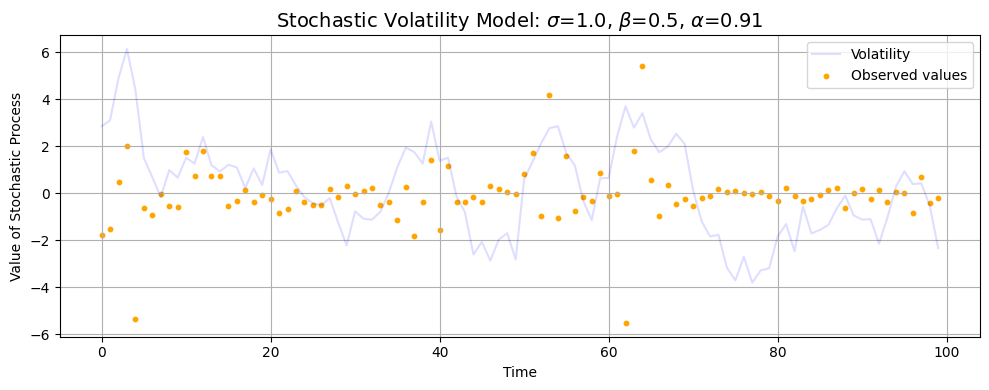

In [119]:
n = 100
hidden_X = [0] * n
Y = [0] * n

sigma = 1.0
beta = 0.5
alpha = 0.91

hidden_X[0] = np.random.normal(0, sigma / (1 - alpha))
Y[0] = beta * np.exp(hidden_X[0] / 2) * np.random.normal(0, 1)

for t in range(1, n):
    hidden_X[t] = alpha * hidden_X[t - 1] + sigma * np.random.normal(0, 1)
    Y[t] = beta * np.exp(hidden_X[t] / 2) * np.random.normal(0, 1)

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(hidden_X, label='Volatility', color='blue', alpha=0.13)
ax.scatter(range(n), Y, label='Observed values', color='orange', s=10, alpha=1.0)

ax.set_title(rf'Stochastic Volatility Model: $\sigma$={sigma}, $\beta$={beta}, $\alpha$={alpha}', fontsize=14)
ax.set_xlabel('Time')
ax.set_ylabel('Value of Stochastic Process')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

For the proposal distribution (the importance distribution) we choose the conditional prior (transition kernel). (Doucet actually leaves this all up to interpretation, so I hope this is true.) That is
$$
q_n(x_n \mid x_{1:n-1}) = q(x_n \mid y_n, x_{n-1}) := p(x_{n} \mid x_{n-1}) = \mathcal{N}(x_n; \alpha x_{n-1}, \sigma^2).
$$


Step one is now to sample $N$ particles from $q(x_1\mid y_1) \equiv \mu(x) = \mathcal{N}\left(0,\frac{\sigma^2}{1-\alpha^2}\right).$

In [120]:
N = 100000
particles = [np.zeros(N) for _ in range(n)]

particles[0] = np.random.normal(loc=0, scale=(sigma**2)/(1-alpha**2), size=N)

Now we have to compute our first batch of weights. Recall that $\{Y_n\}_{n\ge 0}$ evolves according to the transition density $g(y\mid x) = \mathcal{N}(y; 0, \beta^2 \exp(x))$.
We'll import the Gaussian pdfs from `scipy` since we are lazy.

Since we chose the importance distribution to be our transition kernel, we get
$$
w_1(X_1^i) = \frac{\mathcal{N}\left(0,\frac{\sigma^2}{1-\alpha^2}\right)\mathcal{N}(y; 0, \beta^2 \exp(x))}{\mathcal{N}\left(0,\frac{\sigma^2}{1-\alpha^2}\right)} = \mathcal{N}(y; 0, \beta^2 \exp(x)),
$$
which just tells us our weights are proportional to the likelihood function.

In [121]:
from scipy.stats import norm as normal
# yeah, I'm definitely not keeping it named like that
weights = [np.zeros(N) for _ in range(n)]

unnormalized_weights = [np.zeros(N) for _ in range(n)]
likelihoods = [np.zeros(N) for _ in range(n)]
# This of course is superfluous, but we won't always have the unnormalized weights equal to
# the likelihoods
likelihoods[0] = normal.pdf(Y[0], loc=0, scale=beta**2*np.exp(particles[0]))
unnormalized_weights[0] = likelihoods[0]
weights[0] = unnormalized_weights[0] / (np.sum(unnormalized_weights[0]))

No resampling step is performed here in SIS! At this time, and all times forward, we can 
use (Filtering 4) to perform things like kernel density estimation, Metropolis-Hastings, 
resampling / using the approximate sampling technique described by resampling, etc.

We will compute the empirical mean, as well as empirical standard deviation, given our weighted particles.

In [122]:
conditional_expectations = np.zeros(n)
conditional_stddevs = np.zeros(n)

conditional_expectations[0] = np.sum(weights[0] * particles[0])
conditional_stddevs[0] = np.sqrt(np.sum(weights[0] \
                                        * (particles[0] - conditional_expectations[0])**2))

Let's continue for time $t = 2,\ldots, 100$. We need to sample
$$
X^i_n \sim q(x_n \mid y_n, X^i_{n-1}) := p(x_{n} \mid X^i_{n-1}) = \mathcal{N}(x_n; \alpha X^i_{n-1}, \sigma^2).
$$
Once again for the incremental weights $\alpha_n(X_{n-1:n}^i)$, we get
$$
\alpha_n(X_{n-1:n}^i) = \frac{g(y_n \mid X_{n}^i)\cancel{f(X_{n}^i \mid X_{n-1}^i)}}{\cancel{q(X_n^i\mid y_n, X_{n-1}^i)}}= \mathcal{N}(y_n; 0, \beta^2 \exp(X_{n-1}^i)).
$$

In [123]:
for t in range(1,n):
    particles[t] = np.random.normal(loc=particles[t-1], scale=sigma**2, size=N)
    # see above again
    likelihoods[t] = normal.pdf(Y[t], loc=0, scale=beta**2*np.exp(particles[t]))
    unnormalized_weights[t] = likelihoods[t]
    weights[t] = unnormalized_weights[t] / (np.sum(unnormalized_weights[t]))
    conditional_expectations[t] = np.sum(weights[t] * particles[t])
    conditional_stddevs[t] = np.sqrt(np.sum(weights[t \
        ] * (particles[t] - conditional_expectations[t])**2))

We're ready to assemble a plot to see what's going on, and how well our filtering process is doing.

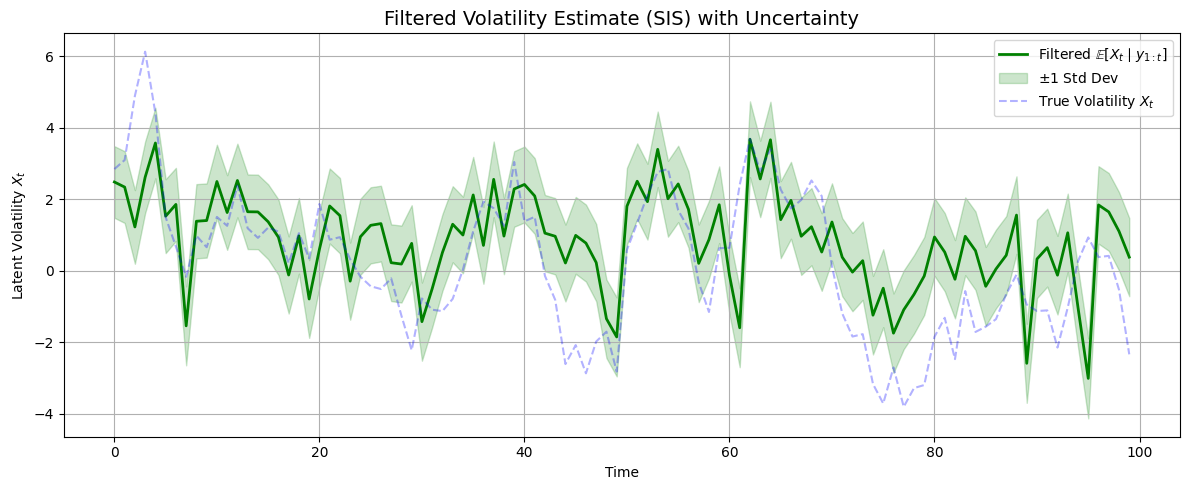

In [124]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(conditional_expectations, label=r'Filtered $\mathbb{E}[X_t \mid y_{1:t}]$', color='green', linewidth=2)

ax.fill_between(
    range(n),
    conditional_expectations - conditional_stddevs,
    conditional_expectations + conditional_stddevs,
    color='green',
    alpha=0.2,
    label=r'$\pm 1$ Std Dev'
)

ax.plot(hidden_X, label='True Volatility $X_t$', color='blue', linestyle='--', alpha=0.3)

ax.set_title(r'Filtered Volatility Estimate (SIS) with Uncertainty', fontsize=14)
ax.set_xlabel('Time')
ax.set_ylabel('Latent Volatility $X_t$')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

Finally, let's add resampling. We perform an extremely simple multinomial resampling step at each iteration without worrying about ESS thresholds.

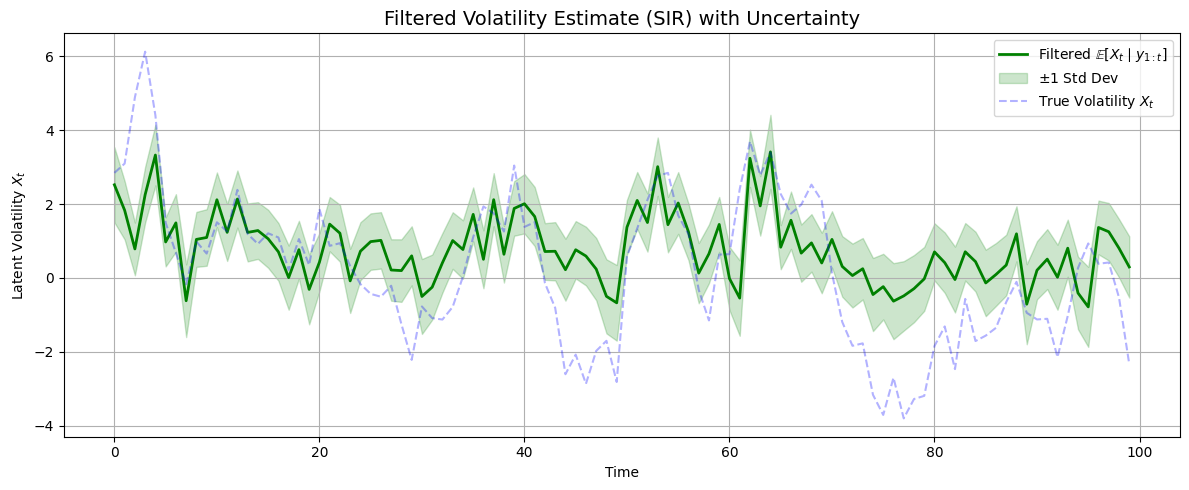

In [125]:
N = 10000
particles = [np.zeros(N) for _ in range(n)]

particles[0] = np.random.normal(loc=0, scale=(sigma**2)/(1-alpha**2), size=N)
weights = [np.zeros(N) for _ in range(n)]

unnormalized_weights = [np.zeros(N) for _ in range(n)]
likelihoods = [np.zeros(N) for _ in range(n)]
likelihoods[0] = normal.pdf(Y[0], loc=0, scale=beta**2*np.exp(particles[0]))
unnormalized_weights[0] = likelihoods[0]
weights[0] = unnormalized_weights[0] / (np.sum(unnormalized_weights[0]))

# Work should be done before resampling
conditional_expectations = np.zeros(n)
conditional_stddevs = np.zeros(n)

conditional_expectations[0] = np.sum(weights[0] * particles[0])
conditional_stddevs[0] = np.sqrt(np.sum(weights[0] \
                                        * (particles[0] - conditional_expectations[0])**2))
# Resample initial particles
resample = np.random.multinomial(N, weights[0])
particles[0] = resample
weights[t] = [1/N]*N
for t in range(1,n):
    particles[t] = np.random.normal(loc=particles[t-1], scale=sigma**2, size=N)
    likelihoods[t] = normal.pdf(Y[t], loc=0, scale=beta**2*np.exp(particles[t]))
    unnormalized_weights[t] = likelihoods[t]
    weights[t] = unnormalized_weights[t] / (np.sum(unnormalized_weights[t]))
    
    conditional_expectations[t] = np.sum(weights[t] * particles[t])
    conditional_stddevs[t] = np.sqrt(np.sum(weights[t \
        ] * (particles[t] - conditional_expectations[t])**2))
    # Resample here
    resample = np.random.multinomial(N, weights[t])
    particles[t] = resample
    weights[t] = [1/N]*N
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(conditional_expectations, label=r'Filtered $\mathbb{E}[X_t \mid y_{1:t}]$', color='green', linewidth=2)

ax.fill_between(
    range(n),
    conditional_expectations - conditional_stddevs,
    conditional_expectations + conditional_stddevs,
    color='green',
    alpha=0.2,
    label=r'$\pm 1$ Std Dev'
)

ax.plot(hidden_X, label='True Volatility $X_t$', color='blue', linestyle='--', alpha=0.3)

ax.set_title(r'Filtered Volatility Estimate (SIR) with Uncertainty', fontsize=14)
ax.set_xlabel('Time')
ax.set_ylabel('Latent Volatility $X_t$')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

### Conclusion and discussion
Since this notebook has become very large we will keep this brief. Multinomial resampling at each iteration is a naive algorithm, qualitatively its performance seems to match that of the nonresampling 